<a href="https://colab.research.google.com/github/hayunjong83/computer_vision_implement_research/blob/master/keras_official_examples/generative_deep_learning/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder
---

원본 글 : [ Variational AutoEncoder](https://keras.io/examples/generative/vae/)

MNIST 데이터셋에서 훈련된 컨볼루션 변이형 오토인코더(Convolutional Variational AutoEncoder)에 관한 예제다.

변이형 오토인코더(**VAE**, Variational AutoEncoder)는 확률적 오토인코더(probablistic autoencoder)이며, 생성 오토인코더(generative autoencoder)다. 가장 기본적인 **딥러닝 생성모델**로서 GAN 학습의 기초가 된다.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## 잠재 벡터(latent vector) 샘플링 ( **reparameterization trick** )
---

VAE의 인코더가 variational inference를 통해 근사한 표준 정규분포에서 무작위로 잠재 벡터를 샘플링을 하면 학습이 불가능하다. 따라서 샘플링 과정에서 원래의 확률적 특성이 보존되고, 미분가능한 모델로 표현할 필요가 있다. 
> 잠재 벡터를 무작위로 샘플링하는 대신, 노이즈를 샘플링한다고 생각할 수 있다.

이 방법이 **reparameterization trick**으로서 가우시안 분포의 평균과 분산을 통해 잠재벡터 z를 샘플링한다.
$$ z_{i} = \mu_{i} + \sigma_{i} \odot \epsilon $$

In [2]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var * epsilon)

사실 변이형 오토인코더에서는 $ \sigma $ 대신에 $ \gamma = log(\sigma^{2}) $ 처럼 *log-scale*로 표현된 값을 주로 사용한다.
> $ \sigma = exp(log(\sigma)) = exp( 2 log(\sigma) * 0.5) = exp(0.5* log(\sigma^{2})) = exp(0.5 * \gamma)$

## 인코더 생성
---

MNIST 데이터셋을 다루는 이번 예제는 이미지에 대한 오토인코더이므로 *컨볼루션(합성곱) 오토인코더*를 만들어 사용한다. 컨볼루션 오토인코더의 인코더는 전형적인 CNN이므로 층을 거치면서 크기는 줄어들지만, 깊이는 깊어진다.

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(16, activation="relu")(x)
z_mean = keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## 디코더 생성
---
컨볼루션 오토인코더에서 디코더는 인코더와는 반대로 이미지의 스케일을 크게하고, 깊이를 원본 차원으로 점차 되돌려간다.

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = keras.layers.Dense(7*7*64, activation="relu")(latent_inputs)
x = keras.layers.Reshape((7, 7, 64))(x)
x = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.models.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## 변이형 오토인코더 모델 정의
---
인코더, 디코더를 케라스 모델로 연결하고, 손실함수와 최적화를 정의한다. 

변이형 오토인코더의 비용함수는 evidence에 대한 ELBO(**E**vidence **L**ower **BO**und)의 음수값이다. ELBO는 두 부분으로 구성되었는데, *재구성 손실(reconstruction loss)*과 *잠재 손실(latent loss)*로 이뤄진다.

재구성 손실은 오토인코더의 출력과 원본 데이터 간의 복원 오차를 의미한다. **크로스 엔트로피**를 통해 표현할 수 있다. 

잠재 손실은 variational inference 과정에서 잠재 벡터를 샘플링한 분포와 실제 코딩의 분포가 유사하도록 만든다. 두 분포 사이의 **KL 발산(Kullback-Leibler divergence)**로 표현된다. 
> 일반적으로 variational inference에서 정규분포를 가정하는 까닭은 정규분포 이외의 분포는 두 분포 간의 KL 발산을 모수 $ \mu, \sigma $ 만을 이용해서 계산하기가 어렵기 때문이다.

$ \mathcal{L} = - {1 \over 2} \sum_{i=1}^N {1 + \gamma_{i} - exp(\gamma_{i}) - \mu^{2}_{i} }$

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var , z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

VAE의 손실함수가 재구성 손실과 KL 발산 손실의 합이지만, *두 손실 간의 균형*을 맞춰줘야 한다.

원래 VAE의 재구성 손실은 픽셀마다 재구성 오차의 합이다. 그런데 케라스의 binary_crossentropy는 합이 아닌 전체 픽셀의 평균을 계산해준다. 따라서 (학습률 조절과 함께) 잠재 손실인 KL 발산 손실을 (28 * 28)로 나눠줘도 괜찮고, 예제처럼 재구성 손실에 784를 곱해줘도 된다.

텐서플로에는 동적으로 그래디언트 값을 확인하게 해주는 [**GradientTape**](https://www.tensorflow.org/tutorials/customization/autodiff?hl=ko) API가 제공된다. GradientTape를 통해 주어진 입력변수에 대한 그래디언트를 계산할 수 있는 *자동 미분(automatic differentiation)*이 가능해진다. GradientTape는 컨텍스트 안에서 실행된 모든 연산을 테이프에 기록하듯 저장한 후 그래디언트 연산을 가능하게 해준다.

## 변이형 오토인코더 훈련
---
공식예제에서는 MNIST의 훈련데이터와 테스트데이터를 합쳐서 70,000개의 데이터로 VAE를 훈련시켰다.

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis= 0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size = 128)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 4s 7ms/step - loss: 202.4316 - reconstruction_loss: 201.8846 - kl_loss: 0.5471
Epoch 2/30
547/547 [==============================] - 4s 7ms/step - loss: 165.3367 - reconstruction_loss: 164.8714 - kl_loss: 0.4653
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - loss: 158.6928 - reconstruction_loss: 158.2442 - kl_loss: 0.4486
Epoch 4/30
547/547 [==============================] - 4s 7ms/step - loss: 154.4791 - reconstruction_loss: 154.0239 - kl_loss: 0.4552
Epoch 5/30
547/547 [==============================] - 4s 7ms/step - loss: 151.8920 - reconstruction_loss: 151.4475 - kl_loss: 0.4445
Epoch 6/30
547/547 [==============================] - 4s 7ms/step - loss: 150.0426 - reconstruction_loss: 149.6130 - kl_loss: 0.4296
Epoch 7/30
547/547 [==============================] - 4s 7ms/step - loss: 148.7969 - reconstruction_loss: 148.3776 - kl_loss: 0.4193
Epoc

## 샘플 숫자의 시각화
---
각 차원이 -2.0부터 2.0의 값을 가지는 2차원 균등분포의 값이 VAE의 디코더에 의해 각각 어떤 숫자로 재구성되는 지를 살펴본다.



In [7]:
import matplotlib.pyplot as plt

def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                   i * digit_size : (i+1) * digit_size,
                   j * digit_size : (j+1) * digit_size,
            ] = digit

    plt.figure(figsize = (figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap = "Greys_r")
    plt.show()

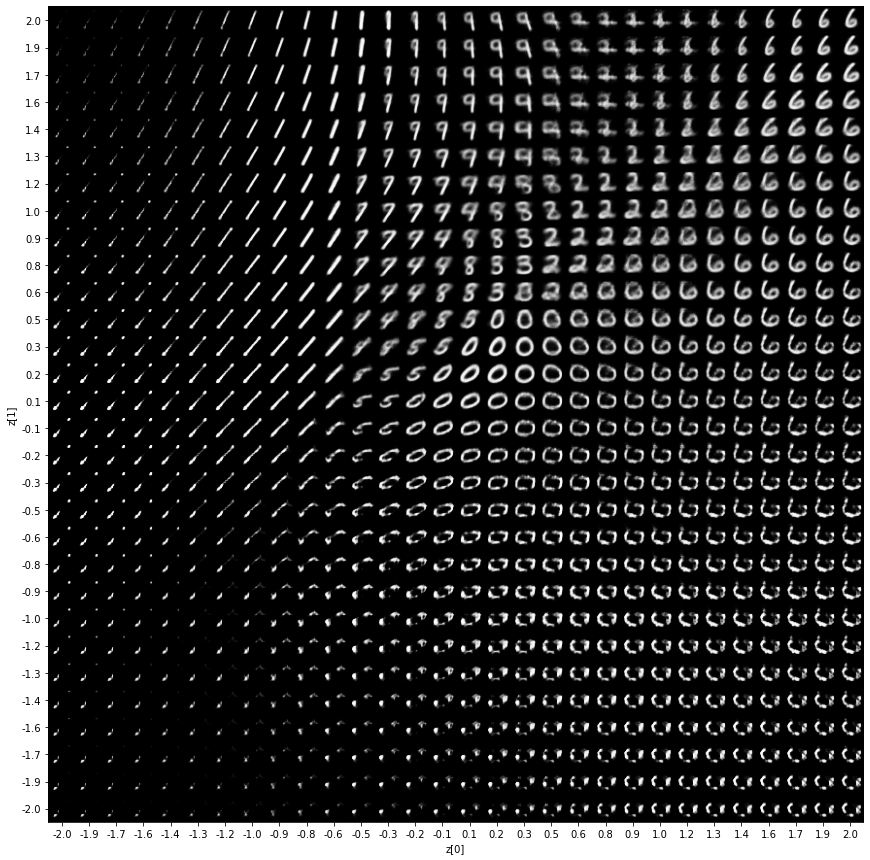

In [8]:
plot_latent(encoder, decoder)

결과적으로 이 결과는 2차원 잠재 공간의 어떤 영역이 디코더에 의해 어떤 숫자로 재구성되는 지를 확인해볼 수 있다. 이것을 생산되는 숫자별로 다른 색으로 시각화한 것이 아래 셀이다.

## 재구성되는 값을 기준으로 잠재공간에서의 클러스터 시각화
---

In [11]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12,10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

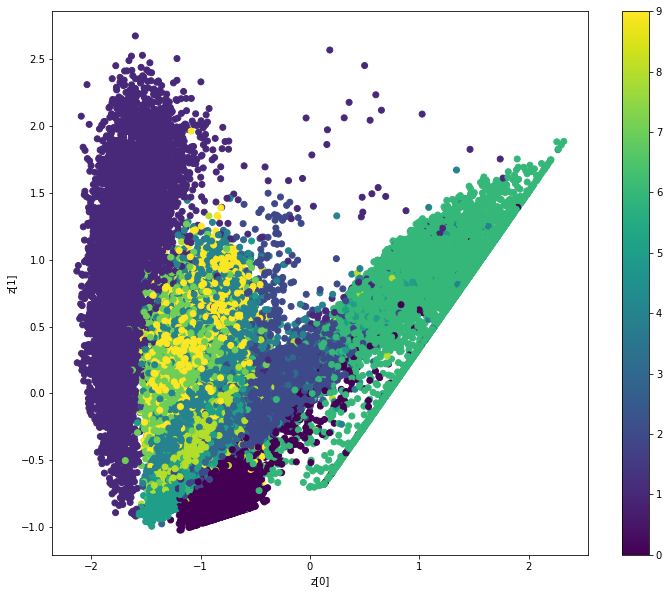

In [12]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)